In [19]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# user defined functions
import odor_statistics_lib as osm
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

# Model theoretical whiff frequency as a gamma distribution with a scale factor that increases with distance

(0.1, 100.0)

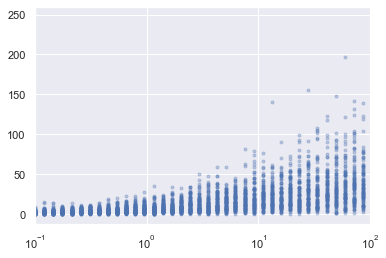

In [32]:
def whiff_freq_from_distance(distance, N):
    scale = 1 + 4*np.log(distance+1)
    G = scipy.stats.gamma(2, 0, scale)
    raw_whiff_frequencies = G.rvs(N)
    return raw_whiff_frequencies

distance = np.logspace(-1, 3)

whiff_freqs = []
distances = []
for d in distance:
    N = 100
    wfs = whiff_freq_from_distance(d, N)
    whiff_freqs.extend( wfs.tolist() )
    distances.extend(N*[d])
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot( np.array(distances), np.array(whiff_freqs), '.', alpha=0.3)
ax.set_xscale('log')
ax.set_xlim(1e-1, 1e2)

# With increasing distance, concentration falls, whiffs harder to detect, so frequency should fall

Model concentration effect as a normal distribution with a mean that falls according to an exponential distribution

(0.1, 100.0)

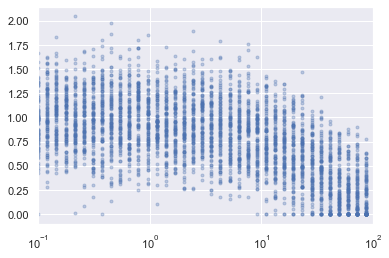

In [33]:
def concentration_effect_from_distance(distance, N):
    mean = scipy.stats.expon(0,40).pdf(d) / 0.025
    concentration_effects = scipy.stats.norm(mean, 0.3).rvs(N)
    concentration_effects[concentration_effects<0] = 0
    return concentration_effects

distance = np.logspace(-1, 3)

conc_effects = []
distances = []
for d in distance:
    N = 100
    ces = concentration_effect_from_distance(d, N)
    conc_effects.extend( ces.tolist() )
    distances.extend(N*[d])
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot( np.array(distances), np.array(conc_effects), '.', alpha=0.3)
ax.set_xscale('log')
ax.set_xlim(1e-1, 1e2)

# Model observed whiff frequency as a product of the two

In [34]:
whiff_freqs = []
distances = []
concentrations = []
for d in distance:
    N = 100
    
    raw_whiff_frequencies = whiff_freq_from_distance(d, N)
    concentration_effects = concentration_effect_from_distance(d, N)
    
    wfs = raw_whiff_frequencies*concentration_effects
    wfs = wfs / 10
    
    whiff_freqs.extend( wfs.tolist() )
    distances.extend(N*[d])
    concentrations.extend(concentration_effects)

(0.0, 8.0)

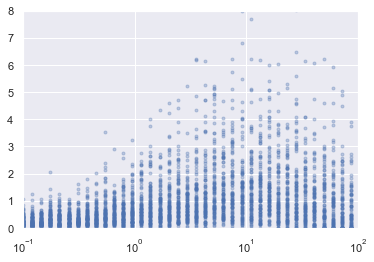

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot( np.array(distances), np.array(whiff_freqs), '.', alpha=0.3)

ax.set_xscale('log')
ax.set_xlim(1e-1, 1e2)
ax.set_ylim(0, 8)

# Try to classify

In [36]:
df = pd.DataFrame({'distance': distances, 
                       'whiff_freq': whiff_freqs, 
                       'concentration': concentrations,
                       'type': [0]*len(whiff_freqs)})

In [37]:
# Assign labels to distance classes

# I forget the right syntax
df.type[df.distance < 5] = 0
df.type[(df.distance > 5)*(df.distance < 30)] = 1
df.type[(df.distance > 30)] = 2

<ipython-input-37-1061a2aa7af3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.type[df.distance < 5] = 0
/Users/an/Documents/MyFiles/DataAnalysis/FlyDataAnalysis/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
<ipython-input-37-1061a2aa7af3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.type[(df.distance > 5)*(df.distance < 30)] = 1
<ipython-input-37-1061a2aa7af3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [112]:
dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/'
df = pd.read_hdf(dir+'NotWindy/NotWindyMASigned.h5')

In [113]:
# df1 = pd.read_hdf(dir+'NotWindy/NotWindyMASigned.h5')

In [114]:
def get_statistics(df,index,fdf):
    osm.avg_distance(df,index,fdf)
    osm.mean_conc(df,index,fdf)
    osm.motion_statistics(df,index,fdf)
    osm.whiff_blank_duration(df,index,fdf)
    osm.trajectory_speed(df,index,fdf)
    osm.encounter_frequency(df,index,fdf,1,2)
    osm.mean_avg(df,index,fdf)
    osm.mean_conc(df,index,fdf)

In [115]:
# np.seterr(divide = 'ignore') 
# index = osm.get_index_forest(df1)
# fdf1 = pd.DataFrame()
# get_statistics(df1,index,fdf1)

In [116]:
np.seterr(divide = 'ignore') 
index = osm.get_index_forest(df)
fdf = pd.DataFrame()
get_statistics(df,index,fdf)

/Users/an/Documents/MyFiles/DataAnalysis/FlyDataAnalysis/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [117]:
fdf['type']=np.zeros(len(fdf))

In [132]:
# I forget the right syntax
fdf.type[fdf.avg_dist_from_source < 5] = 0
fdf.type[(fdf.avg_dist_from_source >= 5)*(fdf.avg_dist_from_source < 10)] = 1
fdf.type[(fdf.avg_dist_from_source >= 10)*(fdf.avg_dist_from_source < 20)] = 2
fdf.type[(fdf.avg_dist_from_source >= 20)*(fdf.avg_dist_from_source < 30)] = 3
fdf.type[(fdf.avg_dist_from_source >= 30)] = 4

/Users/an/Documents/MyFiles/DataAnalysis/FlyDataAnalysis/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/an/Documents/MyFiles/DataAnalysis/FlyDataAnalysis/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/an/Documents/MyFiles/DataAnalysis/FlyDataAnalysis/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


In [133]:
# for each collection of data to use for the classifier, get statistics from N encounters
def get_N_random_encounter_stats(dataframe, distance_class, N):
    df_q = dataframe.query('type == ' + str(distance_class))
    
    Nrows = df_q.sample(N)
    
    return np.ravel( Nrows[['mean_concentration' ,
                            'mean_ef','log_whiff','mean_ma']].values )

In [138]:
# build dataset of N encounters, and labels
X = []
y = []
number_of_encounters = 10
for distance_class in [0, 1, 2, 3, 4]:
    for i in range(len(fdf)):
        X.append(get_N_random_encounter_stats(fdf, distance_class, number_of_encounters))
        y.append(distance_class)
        
X = np.vstack(X)

In [139]:
# Train classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
gnb = GaussianNB()

# test classifier
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

print("Naive Bayes score: ",gnb.score(X_test, y_test))

Number of mislabeled points out of a total 8728 points : 4367
Naive Bayes score:  0.49965627864344636


In [140]:
len(fdf)

3491